# 08wk-1: (합성곱신경망) – MNIST, CIFAR10, XAI란?

다음주 대면수업 없음 ㅇㅇ

## 1. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

## 2. 주요 코드 등

`-` 알렉스넷 아키텍쳐

* Conv : kernel_size = 11, stride = 4
> 먼저 러프하게 보고 싶음 : 처음엔 큰 이미지를 대충대충 보고 싶음

* Pool : kernel_size = 3, stride = 2
> 처음엔 요약하고, 나중엔 요약하지 않고 싶음

* Conv : kernel_size = 3
> 조금 세밀하게 보고 싶음

* 마지막 Pool
> Flatten하기 직전이고, 데이터가 좀 많은 것 같아서 줄여줌

* 신경망 설계 부분
> ReLU : 1d part에서 표현력을 좀 더 얻어내고 싶다.
>
> 요약하고 싶었으면 Linear 한층만 받아도 충분했겠죠

`-` Pytorch

```Python
## 파이토치는 y가 정수형이면 알아서 범주형으로 원-핫 인코딩을 수행함
torch.cuda.empty_cache() ## GPU 메모리 초기화
```

`-` 사전구성 아키텍쳐

```Python
net = torchvision.models.resnet18(pretrained = True) ## 학습된 가중치까지 같이 가져옴
net.fc = torch.nn.Linear(512, 10) ## 레이블의 개수. not iterable. 딕셔너리나 텐서처럼 불러와야 하는듯
```

## 3. MNIST

`#-#` 지난 시간 복습...

* CNN

> `net = 2d -> 1d`
>
> (linr -> ReLU) : 선형변환 -> 비선형변환
>
> (conv -> ReLU -> MP) : 선형변환(행렬곱이니까...) -> 비선형변환 -> 비선형변환
>
> > conv는 특징을 더 다양하게 하기 위한 선형 변환 - conv만 더 많이 취한다고 해서 표현력이 좋아지는 게 아님
> >
> > ReLU는 특징을 더 다양하게 하기 위한 비선형 변환
> >
> > MP는 특징을 더 단순하게 키우기 위한 비선형 변환 -> 요약을 하고 싶은 건데 스트라이딩해서 누를 필요 없음
> 
> 아키텍쳐만 보고도 왜 이렇게 레이어를 잡았는지 파악할 수 있어야 함

`-` 데이터

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=torchvision.transforms.ToTensor())
X,y = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=6000,shuffle=True)))
XX,yy = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=1000,shuffle=True)))

In [6]:
X.shape, y.shape ## 6000장의 흑백 이미지

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [8]:
XX.shape, yy.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [10]:
y ## one-hot encoding이 필요함

tensor([7, 6, 6,  ..., 9, 6, 1])

> one-hot encoding해야 하네? -> 아님
>
> 파이토치는 정수형 자료를 자동으로 범주형으로 인식, 알아서 원-핫 인코딩 해줌

In [19]:
net(X).shape

torch.Size([6000, 3200])

In [26]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5), ## 선형 - (n, 32, 24, 24)
    torch.nn.ReLU(), ## 비선형
    torch.nn.MaxPool2d(kernel_size = 2), ## 비선형 - (n, 32, ???, ???)
    ##---레이어 추가---##
    torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3), ## 위보다 부분적으로 집중해서 보겠다
    torch.nn.ReLU(),
    # torch.nn.MaxPool2d(kernel_size = 2), ## 이미 위에서 충분히 요약된 것 같은데, 또 줄이긴 싫다
    torch.nn.Flatten(),
    torch.nn.Linear(3200, 10)
).to("cuda:0")

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())


#---#
# ds = torch.utils.data.TensorDataset(X)
# dl = torch.utils.data.DataLoader(ds, batch_size = 1024)

X.to("cuda:0")
y.to("cuda:0")

for epoc in range(100) :
    netout = net(X) ## yhat 자체 아님, 로짓임
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [27]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9742, device='cuda:0')

In [28]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.9740, device='cuda:0')

> 개잘함

In [29]:
torch.cuda.empty_cache() ## 캐시 초기화

## 4. CIFAR10

In [30]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=torchvision.transforms.ToTensor())
X,y = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=10000,shuffle=True)))
XX,yy = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=2000,shuffle=True)))

100.0%


### A. 직접 설계

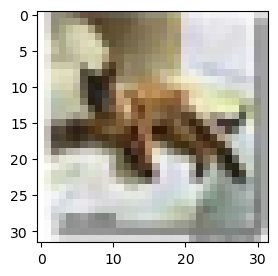

In [33]:
plt.imshow(torch.einsum("chw -> hwc", X[0]))

> 컬러 이미지

In [46]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5), ## 선형 - (n, 32, 24, 24)
    torch.nn.ReLU(), ## 비선형
    torch.nn.MaxPool2d(kernel_size = 2), ## 비선형 - (n, 32, ???, ???)
    ##---레이어 추가---##
    torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3), ## 위보다 부분적으로 집중해서 보겠다
    torch.nn.ReLU(),
    # torch.nn.MaxPool2d(kernel_size = 2), ## 이미 위에서 충분히 요약된 것 같은데, 또 줄이긴 싫다
    torch.nn.Flatten(),
    torch.nn.Linear(4608, 10)
).to("cuda:0")

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())


#---#
# ds = torch.utils.data.TensorDataset(X)
# dl = torch.utils.data.DataLoader(ds, batch_size = 1024)

X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")

for epoc in range(100) :
    netout = net(X) ## yhat 자체 아님, 로짓임
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [47]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.5130, device='cuda:0')

In [48]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.4765, device='cuda:0')

> 표현력이 좀 모자란 것 같음

In [49]:
torch.cuda.empty_cache()

### B. 알렉스넷?

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

* Conv : kernel_size = 11, stride = 4
> 먼저 러프하게 보고 싶음 : 처음엔 큰 이미지를 대충대충 보고 싶음

* Pool : kernel_size = 3, stride = 2
> 처음엔 요약하고, 나중엔 요약하지 않고 싶음

* Conv : kernel_size = 3
> 조금 세밀하게 보고 싶음

* 마지막 Pool
> Flatten하기 직전이고, 데이터가 좀 많은 것 같아서 줄여줌

* 신경망 설계 부분
> ReLU : 1d part에서 표현력을 좀 더 얻어내고 싶다.
>
> 요약하고 싶었으면 Linear 한층만 받아도 충분했겠죠

In [53]:
img = torch.randn(3, 224, 224).reshape(1, 3, 224, 224)
img.shape

torch.Size([1, 3, 224, 224])

In [54]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3, 96, 11, 4), ## 54x54 이미지, 96개 채널(96 유형의 이?미지)
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3, stride = 2), ## 26x26 이미지
    torch.nn.Conv2d(96, 256, 5, padding = 2), ## 외곽 공간에 값이 있다고 치면서 컨볼루션 -> 이미지 크기 고정을 위함
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3, stride = 2), ## 12x12 이미지
    torch.nn.Conv2d(256, 384, kernel_size = 3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384, 384, kernel_size = 3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
    torch.nn.Flatten(),
    torch.nn.Linear(6400, 4096),
    torch.nn.ReLU(),
    torch.nn.dropout(0.5),
    torch.nn.Linear(4096, 4096),
    torch.nn.ReLU(),
    torch.nn.dropout(0.5),
    torch.nn.Linear(4096, 1000) ## output
)

In [56]:
net(img).shape

torch.Size([1, 1000])

### C. 알렉스넷으로 ImageNet 적합

In [57]:
net[-1] = torch.nn.Linear(4096, 10) ## 1000 클래스가 아니라 10 클래스임...

In [63]:
# img = torch.randn(1,3,32,32)
# net(img)

In [61]:
net[:5](img).shape

torch.Size([1, 256, 2, 2])

In [64]:
net[5]

MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)

안됨 ㅠ

> 채널은 256, 이미지 크기는 2x2인데 MP 윈도우 사이즈는 3이여서 찡김...
>
> 이렇게 이미지 크기가 좀 차이만 나도 네트워크 다시 짜야되나...???

### D. renset18

`-` res: <https://arxiv.org/pdf/1512.03385>

In [67]:
net = torchvision.models.resnet18() ## 이미 설계된 아키텍쳐를 가져옴
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

> 마지막 `Linear()`부분만 좀 바꾸면 좋을 것 같음

In [68]:
net[-1] ## sequential이 아님. not subscriptable

TypeError: 'ResNet' object is not subscriptable

In [70]:
net.fc = torch.nn.Linear(512, 10)

In [71]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(500):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
net.eval()

In [72]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(1., device='cuda:0')

In [73]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.5940, device='cuda:0')

> 일단 표현력은 충분히 잘 나옴. 이제 오버피팅만 해결하면 되겠구나!

In [74]:
torch.cuda.empty_cache()

### E. resnet18, pretrained = True

> A를 잘하는 네트워크는 B도 잘할 것 같지 않아?

In [78]:
net = torchvision.models.resnet18(pretrained = True) ## 학습된 가중치까지 같이 가져옴
net.fc = torch.nn.Linear(512, 10)

In [79]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(500):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [ ]:
net.eval()

In [80]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(1., device='cuda:0')

In [81]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.8000, device='cuda:0')

In [ ]:
torch.cuda.empty_cache()

## 5. XAI (eXplainable AI)

<https://brunch.co.kr/@hvnpoet/140>